In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [4]:
from nltk.translate.chrf_score import corpus_chrf

In [5]:
import seaborn as sns

In [6]:
bleu_results = pd.read_csv('./evaluate/all_results_071520.csv')

In [7]:
bleu_results.head()

,method,seed,pair,bleu
0,baseline,10,en-ne,4.6
1,baseline,10,en-si,1.2
2,baseline,10,ne-en,8.3
3,baseline,10,si-en,7.3
4,baseline,11,en-ne,4.4


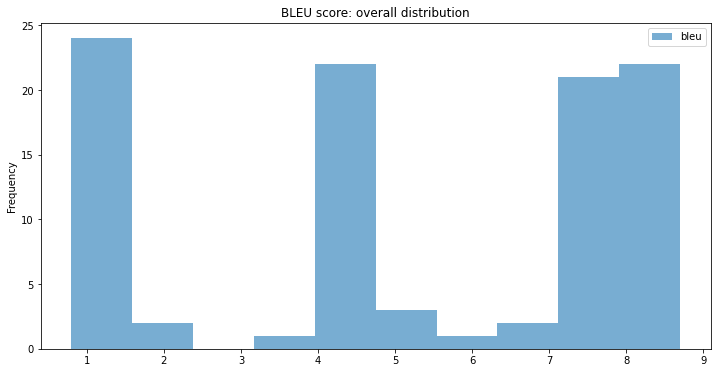

In [8]:
t = 'BLEU score: overall distribution'
bleu_results\
    .bleu.plot(kind='hist', title=t,
               alpha=0.6, figsize=(12, 6),
               legend=True)

method
baseline         AxesSubplot(0.125,0.125;0.775x0.755)
baseline-fp16    AxesSubplot(0.125,0.125;0.775x0.755)
lmvr             AxesSubplot(0.125,0.125;0.775x0.755)
morsel           AxesSubplot(0.125,0.125;0.775x0.755)
subword-nmt      AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

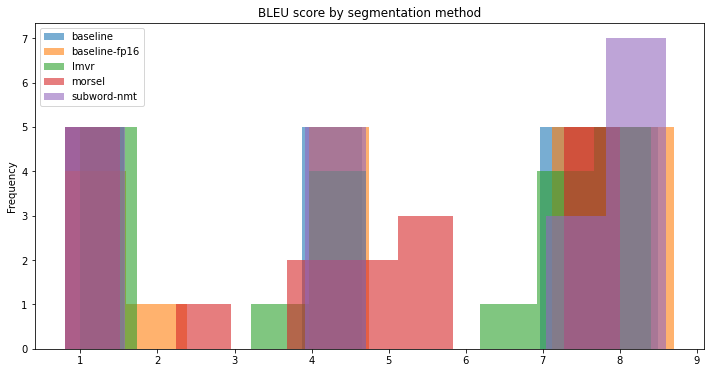

In [9]:
t = 'BLEU score by segmentation method'
bleu_results\
    .groupby(['method'])\
    .bleu.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               legend=True)

pair
en-ne    AxesSubplot(0.125,0.125;0.775x0.755)
en-si    AxesSubplot(0.125,0.125;0.775x0.755)
ne-en    AxesSubplot(0.125,0.125;0.775x0.755)
si-en    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

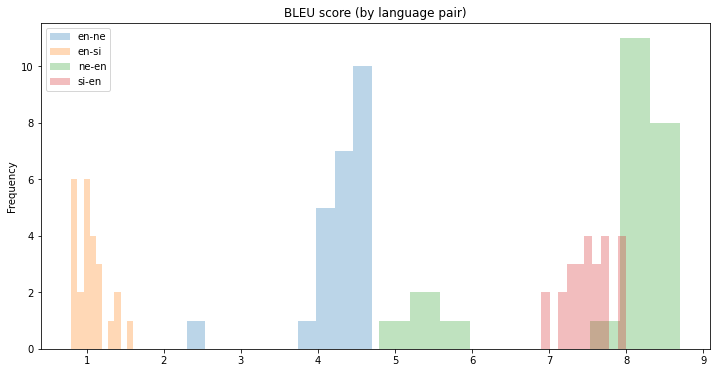

In [10]:
t = 'BLEU score (by language pair)'
bleu_results\
    .groupby('pair')\
    .bleu.plot(kind='hist', title=t,
               alpha=0.3, figsize=(12, 6),
               legend=True)

### Comparison 1: Baseline-FP16 vs. subword-nmt

method
baseline-fp16    AxesSubplot(0.125,0.125;0.775x0.755)
subword-nmt      AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

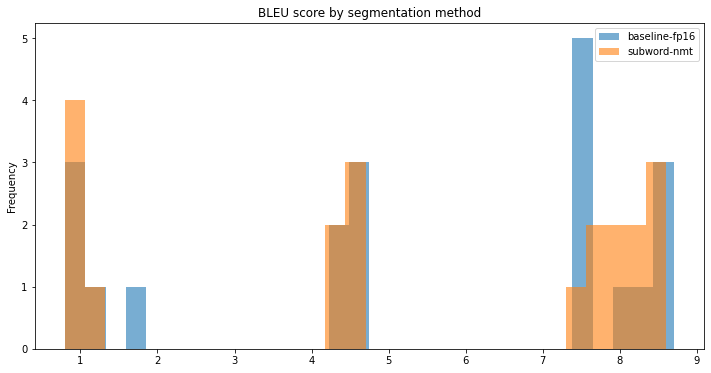

In [11]:
t = 'BLEU score by segmentation method'
baseline_fp16_only = bleu_results.method == 'baseline-fp16'
subword_nmt_only = bleu_results.method == 'subword-nmt'
bleu_results[(baseline_fp16_only)|(subword_nmt_only)]\
    .groupby(['method'])\
    .bleu.plot(kind='hist', title=t, stacked=True,
               alpha=0.6, figsize=(12, 6),
               legend=True, bins=30)

Not very clear -- let's see what we can see when we build a model:

### Modeling BLEU

We'll model things jointly with all the observations baked in at first. We'll use a simple model where BLEU for each directed language pair is modeled as being the sum of a _baseline term_ and a _segmentation method term_.

$$
\text{BLEU}_{l} = \eta_l + \tau_{ml} + \epsilon_l
$$

where $l \in \{\text{ne-en, en-ne, si-en, en-si}\}$ and $m \in \{\text{baseline, baseline-fp16, subword-nmt, lmvr, morsel}\}$.

In [34]:
def posterior_predictive_check(bleu_obs, posterior_pred):
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism['bleu_fake'] = posterior_pred['bleu_observed'][rand_ix]
    criticism['bleu_obs'] = bleu_obs
    criticism.plot(kind='hist', alpha=0.7, title='Posterior predictive check: BLEU', figsize=(12,6), bins=30)

In [35]:
def observed_vs_posterior_predictive_scatter(bleu_obs, posterior_pred, **plot_kwargs):
    if plot_kwargs is None: plot_kwargs = {}
    _ix = np.random.choice(posterior_pred['bleu_observed'].shape[0])
    obs = np.array(bleu_obs)
    samp = posterior_pred['bleu_observed'][_ix]
    df = pd.DataFrame({'bleu_obs': obs, 'bleu_fake': samp})
    ax = df.plot(kind='scatter', x='bleu_obs', y='bleu_fake', 
                 title='BLEU: Observed vs posterior predictive distribution', 
                 **plot_kwargs)    
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color='k', linestyle='dashed')

In [12]:
lang_pair_encoder = LabelEncoder()
segm_method_encoder = LabelEncoder()

In [13]:
lang_pair_data = lang_pair_encoder.fit_transform(bleu_results.pair)

In [14]:
segm_method_data = segm_method_encoder.fit_transform(bleu_results.method)

In [15]:
n_lang_pairs = 4
n_models = 5

In [40]:
(subword_nmt_id, 
baseline_fp16_id, 
morsel_id, lmvr_id) = segm_method_encoder.transform(['subword-nmt', 'baseline-fp16', 'morsel', 'lmvr'])

In [57]:
def fit_bleu_model_a(obs, n=2000, target_accept=0.85):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_models)
        
        tau_subword_nmt = tau[subword_nmt_id]
        tau_baseline_fp16 = tau[baseline_fp16_id]
        tau_morsel = tau[morsel_id]
        tau_lmvr = tau[lmvr_id]
        delta1 = pm.Deterministic('subword_nmt_vs_baseline_fp16', tau_subword_nmt - tau_baseline_fp16)
        delta2 = pm.Deterministic('subword_nmt_vs_lmvr', tau_subword_nmt - tau_lmvr)
        delta3 = pm.Deterministic('subword_nmt_vs_morsel', tau_subword_nmt - tau_morsel)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=obs)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [58]:
bleu_model_a, prior_a, posterior_a, posterior_pred_a = fit_bleu_model_a(bleu_results.bleu, n=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 78 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


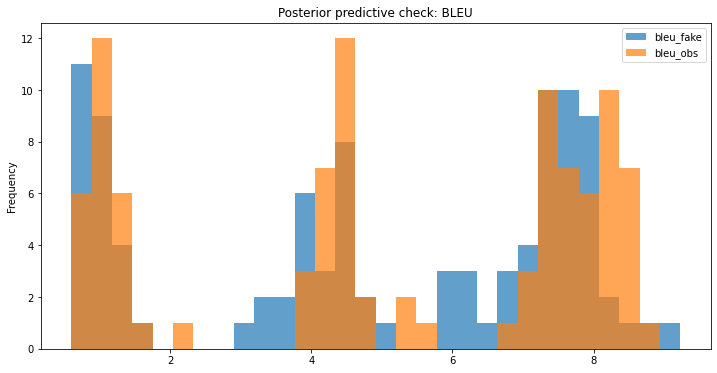

In [59]:
posterior_predictive_check(bleu_results.bleu.to_numpy(), posterior_pred_a)

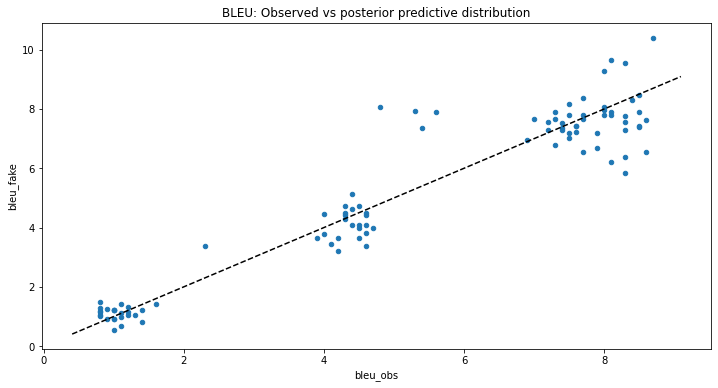

In [60]:
observed_vs_posterior_predictive_scatter(bleu_results.bleu.to_numpy(), posterior_pred_a, figsize=(12,6))

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c73a53710>,
      dtype=object)

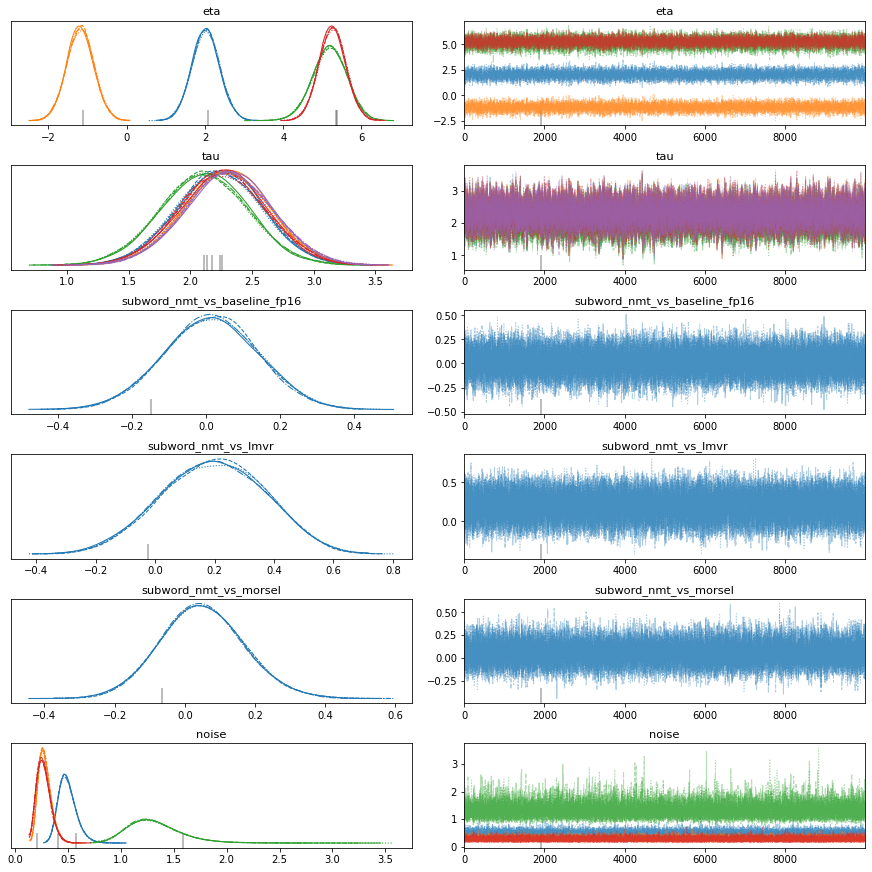

In [61]:
pm.traceplot(posterior_a)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c54ef8b50>],
      dtype=object)

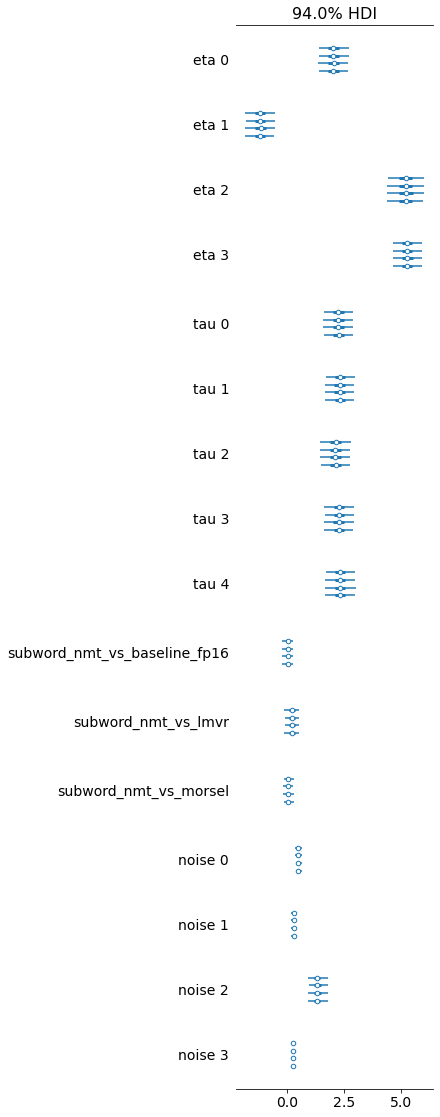

In [67]:
pm.forestplot(posterior_a)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c7146d190>],
      dtype=object)

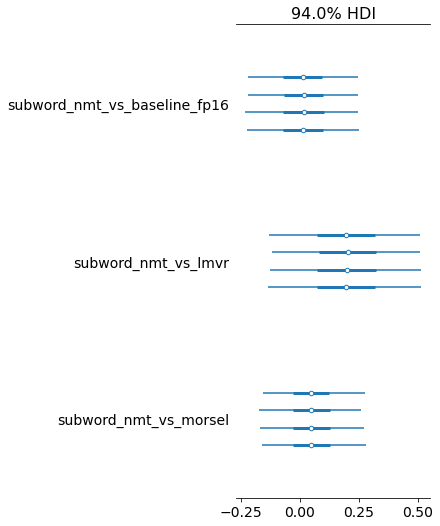

In [66]:
pm.forestplot(posterior_a, var_names=["subword_nmt"], filter_vars="like")